In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.manifold import SpectralEmbedding
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
from mpl_toolkits import mplot3d


In [ ]:
from fig_3_helper import NormalizeData, check_symmetric, compute_laplacian_weighted

## Load data

In [5]:
figs_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_3\fig_3')

In [6]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')

tensor =fl.load(master_path/ 'tensors' /'tensor_ipsi_contra_pos.h5')

features = pd.read_csv(master_path/ 'features_bouts_new.csv')
df_features = pd.read_csv(master_path /'heatmap_features.csv')

tail = tensor[:, 0]
fin_1 = tensor[:,1]
fin_2 = tensor[:,2]

fin_all = np.concatenate((fin_1 ,fin_2),axis=-1)

In [9]:
matrix_fins_cov = fl.load(results_path/ 'matrix_fins_cov.h5')
X_transformed = fl.load(results_path/ 'fin_cov_embeddings.h5')

In [7]:
results_path = master_path / 'Embeddings'

In [8]:
clusters = features.cluster.values
clusters.shape

(11063,)

In [10]:
# fin space cov
X = np.abs(matrix_fins_cov)
X[np.diag_indices_from(X)] = 0

NX_transformed = X_transformed
NX_transformed[:,0] = NormalizeData(X_transformed[:,0])
NX_transformed[:,1] = NormalizeData(X_transformed[:,1])
NX_transformed[:,2] = NormalizeData(X_transformed[:,2])


### Correlate with features

In [11]:
corr_feat_grad = np.zeros((X_transformed.shape[1],df_features.values.shape[1]))

for i in range(df_features.values.shape[1]):
    a0=np.ma.masked_invalid(X_transformed[:,0])
    a1=np.ma.masked_invalid(X_transformed[:,1])
    a2=np.ma.masked_invalid(X_transformed[:,2])

    b=np.ma.masked_invalid(df_features.values[:,i])
    msk0 = (~a0.mask & ~b.mask)
    msk1 = (~a1.mask & ~b.mask)
    msk2 = (~a2.mask & ~b.mask)
    corr_feat_grad[0,i] = np.ma.corrcoef(a0[msk0],b[msk0])[0,1]
    corr_feat_grad[1,i] = np.ma.corrcoef(a1[msk1],b[msk1])[0,1]
    corr_feat_grad[2,i] = np.ma.corrcoef(a2[msk2],b[msk2])[0,1]



In [12]:
alph=0.03
dot_size=3
cm = 1/2.54  # centimeters in inches
f_size = 6
lw = 0.5
dpi=600

## Panel C

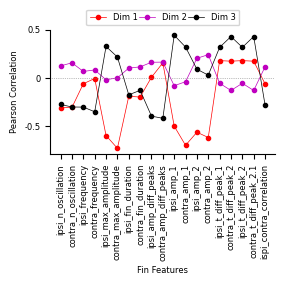

In [15]:
fig, axes = plt.subplots(figsize=(7.5*cm, 7.5*cm), facecolor='None')
axes.plot(corr_feat_grad[0,:],'ro-',label= 'Dim 1', markersize=dot_size, lw=lw)
axes.plot(corr_feat_grad[1,:],'mo-',label= 'Dim 2', markersize=dot_size, lw=lw)
axes.plot(corr_feat_grad[2,:],'ko-',label= 'Dim 3', markersize=dot_size, lw=lw)

axes.set_xticks(np.arange(0,len(df_features.columns),1))
axes.set_xticklabels(np.array(df_features.columns), rotation=90, fontsize=f_size)
axes.set_yticks([-0.5,0, 0.5])
axes.set_yticklabels([-0.5,0, 0.5],fontsize=f_size)

axes.axhline(0, ls=':', c='gray', lw=lw)
axes.set_ylabel('Pearson Correlation', fontsize=f_size)
axes.set_xlabel('Fin Features',fontsize=f_size)
axes.legend(fontsize=f_size, loc='lower center', bbox_to_anchor=(0.5, 1), shadow=False, ncol=3, columnspacing=0.1)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

# if save_figs:
fig.savefig('{}/correlationfeat.pdf'.format(figs_path),format="pdf", bbox_inches="tight", dpi=dpi)
fig.savefig('{}/correlationfeat.png'.format(figs_path),format="png", bbox_inches="tight", dpi=dpi)


### Panel E & F: Amplitude and Frequency

In [ ]:
alph=0.75
f_size = 16

In [ ]:
list_feat_plot = [4,5]
df_feat_plot =  (df_features.values[:,4] +  df_features.values[:,5] )/2


fig = plt.figure(figsize=(10*cm, 10*cm))
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor('none')
sc = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2], alpha=alph, s=dot_size,c=df_feat_plot, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.title('Amplitude', fontsize=f_size)
cbar= plt.colorbar(sc, shrink=0.5, orientation='horizontal',pad=0)
cbar.set_label('Mean Fin Ampl.', size=f_size-2)
cbar.ax.tick_params(labelsize=f_size)
cbar.set_ticks([np.min(df_feat_plot),np.max(df_feat_plot)])
cbar.set_ticklabels([np.round(np.min(df_feat_plot),2),np.round(np.max(df_feat_plot),2)], fontsize=f_size-2)

origin = np.array([0, 0, 0])
u = np.array([1, 0, 0])  # x-axis unit vector
v = np.array([0, 1, 0])  # y-axis unit vector
w = np.array([0, 0, 1])  # z-axis unit vector

# Plot the vectors using quiver
ax.quiver(*origin, *u/3, color='k', label='x-axis (i)', arrow_length_ratio=0.2)
ax.quiver(*origin, *v/3, color='k', label='y-axis (j)', arrow_length_ratio=0.2)
ax.quiver(*origin, *w/3, color='k', label='z-axis (k)', arrow_length_ratio=0.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.tight_layout()
fig.savefig('{}/3DEMB_amp.png'.format(figs_path), format='png', dpi=dpi)

In [ ]:
df_feat_plot =  (df_features.values[:,2]+df_features.values[:,3])/4

fig = plt.figure(figsize=(10*cm, 10*cm))
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor('none')
sc = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2], alpha=alph, s=dot_size,c=df_feat_plot, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.title('Frequency', fontsize=f_size)
cbar= plt.colorbar(sc, shrink=0.5, orientation='horizontal',pad=0)
cbar.set_label('Mean FBF [Hz]', size=f_size-2)
# Setting the fontsize of the colorbar ticks
cbar.ax.tick_params(labelsize=f_size-2)
cbar.set_ticks([np.nanmin(df_feat_plot),np.nanmax(df_feat_plot)])
cbar.set_ticklabels([np.round(np.nanmin(df_feat_plot),2),np.round(np.nanmax(df_feat_plot),2)], fontsize=f_size-2)

origin = np.array([0, 0, 0])
u = np.array([1, 0, 0])  # x-axis unit vector
v = np.array([0, 1, 0])  # y-axis unit vector
w = np.array([0, 0, 1])  # z-axis unit vector

# Plot the vectors using quiver
ax.quiver(*origin, *u/3, color='k', label='x-axis (i)', arrow_length_ratio=0.2)
ax.quiver(*origin, *v/3, color='k', label='y-axis (j)', arrow_length_ratio=0.2)
ax.quiver(*origin, *w/3, color='k', label='z-axis (k)', arrow_length_ratio=0.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.tight_layout()
fig.savefig('{}/3DEMB_frew.png'.format(figs_path), format='png', dpi=dpi)